# 創薬対象となりえる遺伝子リストを取得する

# セットアップ

In [2]:
# Move up to top directory
import os
from pathlib import Path

print(os.getcwd())

while not Path("LICENSE").exists():
    os.chdir('../')

print(os.getcwd())

/mnt/e/Research/TSUMUGI-dev-main/notebooks/notebooks-experiments
/mnt/e/Research/TSUMUGI-dev-main


In [3]:
from pathlib import Path
from pprint import pprint
from collections import defaultdict, Counter
from itertools import combinations
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

P = print
PP = pprint
C = Counter


# 実験

- DGIdb 5.0

https://academic.oup.com/nar/article/52/D1/D1227/7416371

In [ ]:
url = "https://dgidb.org/data/2024-Dec/interactions.tsv"
df_interactions = pd.read_csv(url, sep="\t", comment='#')
df_interactions # 98920 rows

,gene_claim_name,gene_concept_id,gene_name,drug_claim_name,drug_concept_id,drug_name,drug_is_approved,drug_is_immunotherapy,drug_is_antineoplastic,interaction_source_db_name,interaction_source_db_version,interaction_types,interaction_score,drug_specificity_score,gene_specificity_score,evidence_score
0,IGF2,hgnc:5466,IGF2,LINSITINIB,ncit:C70982,LINSITINIB,False,False,True,CIViC,26-November-2024,NaN,0.414316,0.518252,0.799449,1.0
1,IGF2,hgnc:5466,IGF2,DOCETAXEL,rxcui:1299922,DOCETAXEL ANHYDROUS,True,False,True,CIViC,26-November-2024,NaN,0.034942,0.043708,0.799449,1.0
2,IGF2,hgnc:5466,IGF2,CABAZITAXEL,rxcui:996051,CABAZITAXEL,True,False,True,CIViC,26-November-2024,NaN,0.131828,0.164898,0.799449,1.0
3,IGF2,hgnc:5466,IGF2,GEMCITABINE,rxcui:12574,GEMCITABINE,True,False,True,CIViC,26-November-2024,NaN,0.031524,0.039432,0.799449,1.0
4,IGF2,hgnc:5466,IGF2,GANITUMAB,ncit:C71531,GANITUMAB,False,True,True,CIViC,26-November-2024,NaN,0.483369,0.604627,0.799449,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98915,PTPRC,hgnc:9666,PTPRC,PROTEIN KINASE INHIBITOR,ncit:C1404,PROTEIN KINASE INHIBITOR,False,False,False,NCI,14-September-2017,NaN,1.160084,0.725553,0.799449,2.0
98916,PTPRC,hgnc:9666,PTPRC,OESTRADIOL,rxcui:24395,ESTRADIOL VALERATE,True,False,True,NCI,14-September-2017,NaN,0.123413,0.077186,0.799449,2.0
98917,PTPRC,hgnc:9666,PTPRC,PREDNISONE,rxcui:8640,PREDNISONE,True,False,True,NCI,14-September-2017,NaN,0.128898,0.080617,0.799449,2.0
98918,PTPRC,hgnc:9666,PTPRC,HEPARAN SULFATE,rxcui:2603494,HEPARAN SULFATE,False,False,True,NCI,14-September-2017,NaN,0.483369,0.302314,0.799449,2.0


       interaction_score
count       81740.000000
mean            1.411793
std             5.458060
min             0.000392
25%             0.043943
50%             0.175770
75%             0.785020
max           156.611396


<Axes: ylabel='Frequency'>

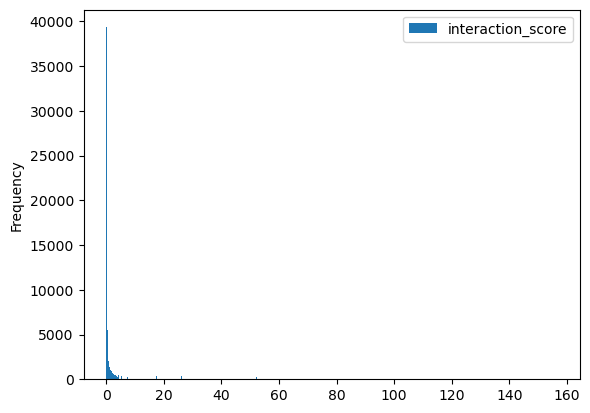

In [10]:
print(df_interactions[["interaction_score"]].describe())
df_interactions[["interaction_score"]].plot.hist(bins=1000)

       evidence_score
count    81740.000000
mean         2.332591
std          7.828750
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        268.000000
None


<Axes: ylabel='Frequency'>

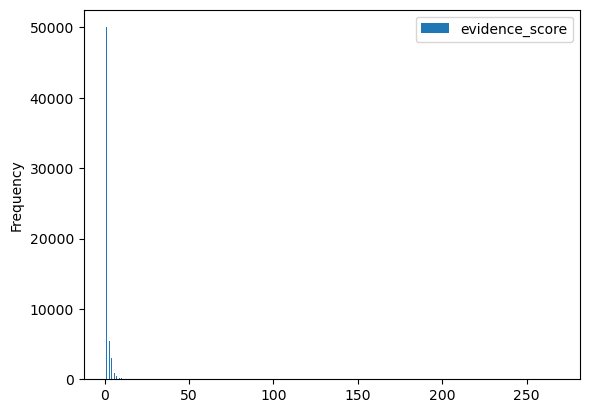

In [11]:
print(print(df_interactions[["evidence_score"]].describe())
)
df_interactions[["evidence_score"]].plot.hist(bins=1000)

In [ ]:
df_interactions_approved = df_interactions[df_interactions["drug_is_approved"] == True]
df_interactions_approved # 38483 rows

,gene_claim_name,gene_concept_id,gene_name,drug_claim_name,drug_concept_id,drug_name,drug_is_approved,drug_is_immunotherapy,drug_is_antineoplastic,interaction_source_db_name,interaction_source_db_version,interaction_types,interaction_score,drug_specificity_score,gene_specificity_score,evidence_score
1,IGF2,hgnc:5466,IGF2,DOCETAXEL,rxcui:1299922,DOCETAXEL ANHYDROUS,True,False,True,CIViC,26-November-2024,NaN,0.034942,0.043708,0.799449,1.0
2,IGF2,hgnc:5466,IGF2,CABAZITAXEL,rxcui:996051,CABAZITAXEL,True,False,True,CIViC,26-November-2024,NaN,0.131828,0.164898,0.799449,1.0
3,IGF2,hgnc:5466,IGF2,GEMCITABINE,rxcui:12574,GEMCITABINE,True,False,True,CIViC,26-November-2024,NaN,0.031524,0.039432,0.799449,1.0
5,MC1R,hgnc:6929,MC1R,isoflurane,rxcui:6026,ISOFLURANE,True,False,True,PharmGKB,2024-04-05,NaN,0.481141,0.117025,2.055725,2.0
6,MC1R,hgnc:6929,MC1R,desipramine,rxcui:3247,DESIPRAMINE,True,False,True,PharmGKB,2024-04-05,NaN,0.382445,0.093020,2.055725,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98910,PTPRC,hgnc:9666,PTPRC,CORTISOL,rxcui:103468,HYDROCORTISONE BUTYRATE,True,False,True,NCI,14-September-2017,NaN,0.138105,0.086375,0.799449,2.0
98912,PTPRC,hgnc:9666,PTPRC,5-FU,rxcui:4492,FLUOROURACIL,True,False,True,NCI,14-September-2017,NaN,0.050004,0.031274,0.799449,2.0
98914,PTPRC,hgnc:9666,PTPRC,ERYTHROPOIETIN,rxcui:105694,EPOETIN ALFA,True,False,True,NCI,14-September-2017,NaN,0.170601,0.106699,0.799449,2.0
98916,PTPRC,hgnc:9666,PTPRC,OESTRADIOL,rxcui:24395,ESTRADIOL VALERATE,True,False,True,NCI,14-September-2017,NaN,0.123413,0.077186,0.799449,2.0


In [15]:
df_interactions_approved_high_eveidence = df_interactions_approved[df_interactions_approved["evidence_score"] >= 2]
df_interactions_approved_high_eveidence # 20452 rows

,gene_claim_name,gene_concept_id,gene_name,drug_claim_name,drug_concept_id,drug_name,drug_is_approved,drug_is_immunotherapy,drug_is_antineoplastic,interaction_source_db_name,interaction_source_db_version,interaction_types,interaction_score,drug_specificity_score,gene_specificity_score,evidence_score
5,MC1R,hgnc:6929,MC1R,isoflurane,rxcui:6026,ISOFLURANE,True,False,True,PharmGKB,2024-04-05,NaN,0.481141,0.117025,2.055725,2.0
6,MC1R,hgnc:6929,MC1R,desipramine,rxcui:3247,DESIPRAMINE,True,False,True,PharmGKB,2024-04-05,NaN,0.382445,0.093020,2.055725,2.0
7,OR52E2,hgnc:14769,OR52E2,lithium,rxcui:6448,LITHIUM,True,False,False,PharmGKB,2024-04-05,NaN,2.485895,0.086375,14.390078,2.0
11,ICAM3,hgnc:5346,ICAM3,VITAMIN D,rxcui:11253,VITAMIN D,True,False,False,NCI,14-September-2017,NaN,1.003919,0.279059,1.798760,2.0
13,ICAM3,hgnc:5346,ICAM3,METHOTREXATE,rxcui:6851,METHOTREXATE,True,False,True,NCI,14-September-2017,NaN,0.118645,0.032980,1.798760,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98910,PTPRC,hgnc:9666,PTPRC,CORTISOL,rxcui:103468,HYDROCORTISONE BUTYRATE,True,False,True,NCI,14-September-2017,NaN,0.138105,0.086375,0.799449,2.0
98912,PTPRC,hgnc:9666,PTPRC,5-FU,rxcui:4492,FLUOROURACIL,True,False,True,NCI,14-September-2017,NaN,0.050004,0.031274,0.799449,2.0
98914,PTPRC,hgnc:9666,PTPRC,ERYTHROPOIETIN,rxcui:105694,EPOETIN ALFA,True,False,True,NCI,14-September-2017,NaN,0.170601,0.106699,0.799449,2.0
98916,PTPRC,hgnc:9666,PTPRC,OESTRADIOL,rxcui:24395,ESTRADIOL VALERATE,True,False,True,NCI,14-September-2017,NaN,0.123413,0.077186,0.799449,2.0


In [20]:
druggable_genes = df_interactions_approved_high_eveidence["gene_name"].unique()
print(len(druggable_genes)) # 2265

2265


In [22]:
# ソートして出力

Path("data/experiments/").mkdir(parents=True, exist_ok=True)
druggable_genes = sorted(druggable_genes)
with open("data/experiments/druggable_genes.txt", "w") as f:
    for gene in druggable_genes:
        f.write(gene + "\n")


## ヒトからマウスの遺伝子シンボルに変換

In [43]:
url = "https://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt"

df_mouse_human = pd.read_csv(url, sep="\t", comment='#')
df_mouse_human # 1081 rows

,DB Class Key,Common Organism Name,NCBI Taxon ID,Symbol,EntrezGene ID,Mouse MGI ID,HGNC ID,OMIM Gene ID,Genetic Location,Genome Coordinates (mouse: GRCm39 human: GRCh38),Nucleotide RefSeq IDs,Protein RefSeq IDs,SWISS_PROT IDs
0,48820146,"mouse, laboratory",10090,Aldh1l1,107747,MGI:1340024,NaN,NaN,Chr6 40.16 cM,Chr6:90527751-90576153(+),"NM_001356412,XM_030255052,NM_027406","NP_081682,NP_001343341,XP_030110912",Q8R0Y6
1,48820146,human,9606,ALDH1L1,10840,NaN,HGNC:3978,OMIM:600249,Chr3 q21.3,Chr3:126103562-126197994(-),"NM_001270365,NM_144776,NM_012190,NM_001270364","XP_016861102,XP_024309093,XP_054201003,XP_0542...",O75891
2,48820147,"mouse, laboratory",10090,Sry,21674,MGI:98660,NaN,NaN,ChrY syntenic,ChrY:2662471-2663658(-),NM_011564,NP_035694,Q05738
3,48820147,human,9606,SRY,6736,NaN,HGNC:11311,OMIM:480000,ChrY p11.2,ChrY:2786855-2787682(-),NM_003140,NP_003131,Q05066
4,48820148,"mouse, laboratory",10090,Fry,320365,MGI:2443895,NaN,NaN,Chr5 89.36 cM,Chr5:150042110-150421218(+),"XM_006504932,XM_030254574,XM_006504933,XM_0065...","XP_006504994,NP_766475,XP_006504991,XP_0065049...",E9Q8I9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46393,48841954,"mouse, laboratory",10090,Zfp964,636741,MGI:3646490,NaN,NaN,Chr8 33.88 cM,Chr8:70107129-70119632(+),"XM_011242316,NM_001177527","XP_011240618,NP_001170998",NaN
46394,48841955,"mouse, laboratory",10090,Gm12258,108167848,MGI:3651534,NaN,NaN,Chr11 36.33 cM,Chr11:58737984-58752782(+),"XM_036156222,NM_001372582,NM_001372581","NP_001359510,NP_001359511,XP_036012115",NaN
46395,48841956,"mouse, laboratory",10090,Zim1,22776,MGI:1341879,NaN,NaN,Chr7 3.87 cM,Chr7:6677443-6699521(-),"XM_011250498,XM_011250499,NM_011769,XM_0112504...","NP_035899,XP_011248800,XP_011248801,XP_0112487...",NaN
46396,48841957,"mouse, laboratory",10090,9030624G23Rik,66808,MGI:1914058,NaN,NaN,Chr12 8.46 cM,Chr12:24093529-24147257(-),"XM_036157580,NM_001382819,NM_001256489","NP_001243418,NP_001369748,XP_036013473",NaN


In [45]:
# 種名から 'mouse' or 'human' を抽出
df_mouse_human['Organism'] = df_mouse_human['Common Organism Name'].str.extract(r'(mouse|human)', expand=False)
df = df_mouse_human[["DB Class Key", "Organism", "Symbol"]]
df

,DB Class Key,Organism,Symbol
0,48820146,mouse,Aldh1l1
1,48820146,human,ALDH1L1
2,48820147,mouse,Sry
3,48820147,human,SRY
4,48820148,mouse,Fry
...,...,...,...
46393,48841954,mouse,Zfp964
46394,48841955,mouse,Gm12258
46395,48841956,mouse,Zim1
46396,48841957,mouse,9030624G23Rik


In [46]:
# human/mouseごとの Symbol を分けて抽出
human_df = df[df["Organism"] == "human"][["DB Class Key", "Symbol"]].rename(columns={"Symbol": "human"})
mouse_df = df[df["Organism"] == "mouse"][["DB Class Key", "Symbol"]].rename(columns={"Symbol": "mouse"})


In [52]:
df_merged = pd.merge(human_df, mouse_df, on="DB Class Key", how="left").reset_index(drop=True)
df_merged[["human", "mouse"]].drop_duplicates().to_csv("data/experiments/human_mouse_genes.txt", sep="\t", index=False)

In [50]:
df_merged[df_merged["DB Class Key"] == 48820152]

,DB Class Key,human,mouse
6,48820152,HSD3B1,Hsd3b4
7,48820152,HSD3B2,Hsd3b4


## マウスにおけるDruggable genesのリストを作成

In [55]:
druggable_genes[:10]

['A2M',
 'AADAC',
 'AANAT',
 'ABAT',
 'ABCA1',
 'ABCA3',
 'ABCB1',
 'ABCB11',
 'ABCB4',
 'ABCB5']

In [59]:
human_mouse = {df_merged.iloc[i]["human"]: df_merged.iloc[i]["mouse"] for i in range(len(df_merged))}
human_mouse["TP53"] # Trp53

'Trp53'

In [62]:
druggable_genes_mouse = []
for gene in druggable_genes:
    if gene in human_mouse:
        druggable_genes_mouse.append(human_mouse[gene])

druggable_genes_mouse = sorted(druggable_genes_mouse)
with open("data/experiments/druggable_genes_mouse.txt", "w") as f:
    for gene in druggable_genes_mouse:
        f.write(gene + "\n")
print(len(druggable_genes))
print(len(druggable_genes_mouse)) # 2189

2265
2189
